In [1]:
import torch as _torch
import numpy as np
import vamb4
from vamb4 import graph
import latent_visual
import matplotlib.pyplot as plt
import json
import os
import seaborn as sns
import pandas as pd

## boxplot for overlap ratio

In [186]:
dataset_list = ['airways','gi','oral','skin','urog']

ratios_dict_ori = {}
ratios_value_dict_ori = {}
for dataset in dataset_list:
    with open('original/{}/ratios_0502.json'.format(dataset),'r') as f:
        ratios = json.load(f)
    ratios_dict_ori[dataset] = ratios
    ratios_value_dict_ori[dataset] = [ratio for ratio,_,_ in ratios.values()]


ratios_dict_sage = {}
ratios_value_dict_sage = {}
for dataset in dataset_list:
    with open('sage_nodist/graph/{}/ratios_0506.json'.format(dataset),'r') as f:
        ratios = json.load(f)
    ratios_dict_sage[dataset] = ratios
    ratios_value_dict_sage[dataset] = [ratio for ratio,_,_ in ratios.values()]


df_ori_list = []
for dataset, ratios_value in ratios_value_dict_ori.items():
    df = pd.DataFrame({'ratio_value':ratios_value})
    df['dataset'] = dataset
    df_ori_list.append(df)
df_ori = pd.concat(df_ori_list)
df_ori['model'] = 'Linear-layer'

df_sage_list = []
for dataset, ratios_value in ratios_value_dict_sage.items():
    df = pd.DataFrame({'ratio_value':ratios_value})
    df['dataset'] = dataset
    df_sage_list.append(df)
df_sage = pd.concat(df_sage_list)
df_sage['model'] = 'GraphSage-layer'

df_both = pd.concat([df_ori,df_sage])

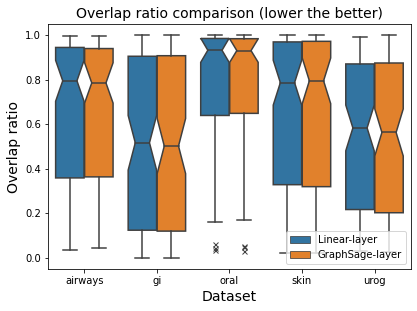

In [180]:
fig, ax = plt.subplots(figsize=(6.5, 4.5))
sns.boxplot(data=df_both,x='dataset',y='ratio_value',hue='model',notch=True, flierprops={"marker": "x"},ax=ax)
ax.set_xlabel('Dataset',fontdict={'fontsize':14})
ax.set_ylabel('Overlap ratio',fontdict={'fontsize':14})
ax.legend(loc='lower right')
ax.set_title('Overlap ratio comparison (lower the better)',fontdict={'fontsize':14})

plt.savefig('graphvamb_plot/ori_sagenodict_boxplot.png',dpi=300)

In [2]:
dataset = 'oral'
foldname_list = ['Cosdistloss','cosdist_neg','GraphSage','Sagenewloss','Sagenewloss_z','Sagenewloss_z_neg']
weights_list = [0.1,0.01,0.001,0.0001,0]
name_list = ['original','lin_cos','lin_cos_neg','sage_cos','sage_edge','sage_edge_z','sage_edge_z_neg']

In [3]:
with open('errorfree/ori/ratios_oral_0504.json'.format(dataset), 'r') as f:
    ratios_ori = json.load(f)
ratios_ori_value = [ratio for ratio,_,_ in ratios_ori.values()]

In [4]:
model_ratios_dict = {} # model:ratios_dict
model_ratios_value_dict = {} # model: ratios_value
for i,foldname in enumerate(foldname_list):
    ratios_list_onemodel = [ratios_ori]
    ratios_value_list_onemodel = [ratios_ori_value]
    for weight in weights_list:
        with open('{}/{}/ratios_{}.json'.format(foldname,dataset,weight), 'r') as f:
            ratios = json.load(f)
        ratios_list_onemodel.append(ratios)
        ratios_value_list_onemodel.append([ratio for ratio,_,_ in ratios.values()])
    model_ratios_dict[name_list[i+1]] = ratios_list_onemodel
    model_ratios_value_dict[name_list[i+1]] = ratios_value_list_onemodel

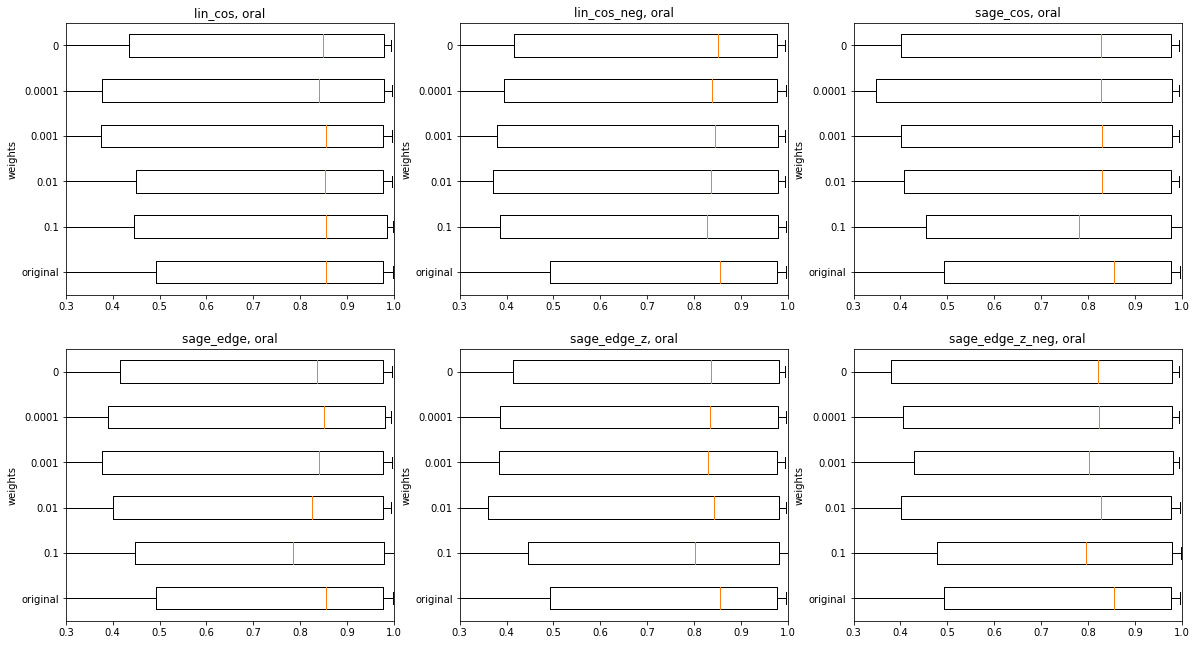

In [5]:
plt.figure(figsize=(20,17))
y_label = ['original','0.1','0.01','0.001','0.0001','0']
for i in range(1,7):
    plt.subplot(3,3,i)
    plt.boxplot(model_ratios_value_dict[name_list[i]],vert=False)
    loc = range(1,len(y_label)+1)
    plt.yticks(loc, y_label)
    plt.xlim((0.3,1))
    plt.ylabel('weights')
    plt.title('{}, {}'.format(name_list[i],dataset))

Text(0.5, 1.0, 'weight=0, dataset=oral')

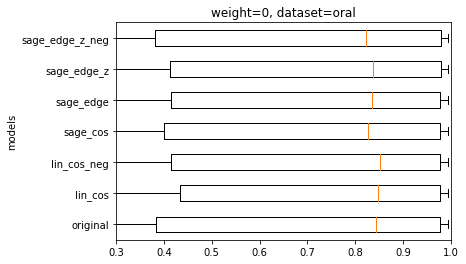

In [88]:
choose_weight = 0
choose_weight_idx = weights_list.index(choose_weight) + 1
x = [ratios_ori_value] + [model_ratios_value_dict[name_list[i+1]][choose_weight_idx] for i in range(6)]
plt.boxplot(x,vert=False)
loc = range(1,len(name_list)+1)
plt.yticks(loc, name_list)
plt.xlim((0.3,1))
plt.ylabel('models')
plt.title('weight={}, dataset={}'.format(choose_weight,dataset))

## plot overlap for specific genome

In [2]:
def _calc_distances(matrix: _torch.Tensor, index: int) -> _torch.Tensor:
    "Return vector of cosine distances from rows of normalized matrix to given row."
    dists = 0.5 - matrix.matmul(matrix[index])
    dists[index] = 0.0  # avoid float rounding errors
    return dists
def _calc_densities(
    histogram, pdf = vamb4.cluster._NORMALPDF
):
    """Given an array of histogram, smoothes the histogram."""
    pdf_len = len(pdf)

    densities = _torch.zeros(len(histogram) + pdf_len - 1)
    for i in range(len(densities) - pdf_len + 1):
        densities[i : i + pdf_len] += pdf * histogram[i]

    densities = densities[15:-15]

    return densities
def plot_ratio(matrix,genome_idx,ratios_dict,genome_contig_dict,name):
    genome_i = list(ratios_dict.keys())[genome_idx]
    center = ratios_dict[genome_i][1]
    ingenome_idx = genome_contig_dict[genome_i]
    outgenome_idx = [i for i in range(len(matrix)) if i not in genome_contig_dict[genome_i]]
    dist = _calc_distances(matrix,center)
    within_distances = dist[ingenome_idx]
    without_distances = dist[outgenome_idx]
    histogram_within = _torch.empty((180,))
    histogram_without = _torch.empty((180,))
    dens = []
    for (h, d) in ((histogram_within, within_distances), (histogram_without, without_distances)):
        _torch.histc(d, len(histogram_within), 0, 0.9, out=h)
        h[0] -= 1  # Remove distance to self
        dens.append(_calc_densities(h))
    densities_within, densities_without = dens
    sum_overlap = sum(np.stack((densities_within,densities_without),axis=1).min(axis=1)).clip(min=0)
    sum_within = sum(densities_within)
    ratio = sum_overlap/sum_within
    # print('genome:',genome_i)
    # print('Overlap/within ratio:',ratio)
    # print("Number of in-genome contigs before 0.3:",sum(within_distances < 0.3))
    # print("Number of in-genome contigs after 0.3:",sum(within_distances > 0.3))
    return densities_within, densities_without

    # plt.plot([i*0.005 for i in range(180)], densities_within[:180])
    # plt.plot([i*0.005 for i in range(180)], densities_without[:180])
    # plt.ylim(0, 50)
    # plt.xlim(0, 0.5)
    # plt.title('{},{}, {}'.format(name,round(ratio.item(),3),genome_i))

### read the genome_contigs dist and latent matrix, ratios_dict of each model

In [190]:
with open('genome_contigs_oral_dict.json','r') as f:
    genome_contigs = json.load(f)

In [285]:
matrix_ori = _torch.load('errorfree/thesis_ef/ori/latent_oral_0510ori_200_0.npz')
lat_ori = vamb4.cluster._normalize(matrix_ori)
matrix_sage_no = _torch.load('errorfree/thesis_ef/sage_no/latent_oral_0510_200_0.npz')
lat_sage_no = vamb4.cluster._normalize(matrix_sage_no)

matrix_lin_sage = _torch.load('errorfree/thesis_ef/lin_sage/latent_oral_0510_200_0.1.npz')
lat_lin_sage = vamb4.cluster._normalize(matrix_lin_sage)
matrix_lin_cos = _torch.load('errorfree/thesis_ef/lin_cos/latent_oral_0510_200_0.1.npz')
lat_lin_cos = vamb4.cluster._normalize(matrix_lin_cos)
matrix_sage_cos = _torch.load('errorfree/thesis_ef/sage_cos/latent_oral_0510_200_0.1.npz')
lat_sage_cos = vamb4.cluster._normalize(matrix_sage_cos)
matrix_sage_sage = _torch.load('errorfree/thesis_ef/sage_sage/latent_oral_0510_200_0.1.npz')
lat_sage_sage = vamb4.cluster._normalize(matrix_sage_sage)

matrix_lin_sage_mu = _torch.load('errorfree/thesis_ef/lin_sage/latent_oral_0510mu_200_0.1.npz')
lat_lin_sage_mu = vamb4.cluster._normalize(matrix_lin_sage_mu)
matrix_lin_cos_mu = _torch.load('errorfree/thesis_ef/lin_cos/latent_oral_0510mu_200_0.1.npz')
lat_lin_cos_mu = vamb4.cluster._normalize(matrix_lin_cos_mu)
matrix_sage_cos_mu = _torch.load('errorfree/thesis_ef/sage_cos/latent_oral_0510mu_200_0.1.npz')
lat_sage_cos_mu = vamb4.cluster._normalize(matrix_sage_cos_mu)
matrix_sage_sage_mu = _torch.load('errorfree/thesis_ef/sage_sage/latent_oral_0510mu_200_0.1.npz')
lat_sage_sage_mu = vamb4.cluster._normalize(matrix_sage_sage_mu)

In [286]:
with open('errorfree/thesis_ef/ori/ratios_0510ori_200_0.json','r') as f:
    ratios_ori = json.load(f)
with open('errorfree/thesis_ef/sage_no/ratios_0510_200_0.json','r') as f:
    ratios_sage_no = json.load(f)

with open('errorfree/thesis_ef/lin_sage/ratios_0510_200_0.1.json','r') as f:
    ratios_lin_sage = json.load(f)
with open('errorfree/thesis_ef/lin_cos/ratios_0510_200_0.1.json','r') as f:
    ratios_lin_cos = json.load(f)
with open('errorfree/thesis_ef/sage_sage/ratios_0510_200_0.1.json','r') as f:
    ratios_sage_sage = json.load(f)
with open('errorfree/thesis_ef/sage_cos/ratios_0510_200_0.1.json','r') as f:
    ratios_sage_cos = json.load(f)
    
with open('errorfree/thesis_ef/lin_sage/ratios_0510mu_200_0.1.json','r') as f:
    ratios_lin_sage_mu = json.load(f)
with open('errorfree/thesis_ef/lin_cos/ratios_0510mu_200_0.1.json','r') as f:
    ratios_lin_cos_mu = json.load(f)
with open('errorfree/thesis_ef/sage_sage/ratios_0510mu_200_0.1.json','r') as f:
    ratios_sage_sage_mu = json.load(f)
with open('errorfree/thesis_ef/sage_cos/ratios_0510mu_200_0.1.json','r') as f:
    ratios_sage_cos_mu = json.load(f)

### create overlap curve of a specific genome for each model

In [64]:
high_ratio_genome_idx_list = []
for i, ratios in enumerate(list(ratios_ori.values())):
    ratio_value,_,ningenome = ratios
    if ratio_value < 0.2 and ningenome> 500:
        high_ratio_genome_idx_list.append((i,ratio_value))

In [50]:
import importlib
importlib.reload(vamb4.graph)
dataset = 'oral'
composition = vamb4.parsecontigs.Composition.load('/Users/liuxinyuan/Desktop/master_thesis/data/oral/errorfree/vambout/composition.npz')
abundance = vamb4.parsebam.Abundance.load("/Users/liuxinyuan/Desktop/master_thesis/data/oral/errorfree/vambout/abundance.npz", composition.metadata.refhash)
identifiers = list(composition.metadata.identifiers)
graph_dict = vamb4.graph.neighbors_dict('/Users/liuxinyuan/Desktop/master_thesis/week9/new_assebgraph/oral/neighbours_dg_10_only_TPs.txt',list(identifiers))

In [83]:
high_dp_genome_idx_list = []
for genome_id, contigs in genome_contig.items():
    n_dp = 0
    for contig in contigs:
        if len(graph_dict[contig]) > 0:
            n_dp += 1
    if n_dp/len(contigs) > 0.6:
        high_dp_genome_idx_list.append(genome_id)

In [309]:
choose_genomes = list(ratios_ori.keys())
select_genomes = ['OTU_97.20.0', 'OTU_97.27797.0', 'OTU_97.429.0', 'OTU_97.31969.0']
genome_name = list(set(select_genomes).intersection(set(choose_genomes)))[0]
print(genome_name)
genome_idx = choose_genomes.index(genome_name)
print(genome_idx)

OTU_97.20.0
81


In [ ]:
select_genomes = ['OTU_97.20.0', 'OTU_97.27797.0', 'OTU_97.429.0', 'OTU_97.31969.0']

In [323]:
genome_i = list(ratios_ori.keys())[99]

In [327]:
len(genome_contigs[genome_i])

632

In [335]:
a = 0
for contig in genome_contigs[genome_i]:
    if len(graph_dict[contig]) > 0:
        a+=1
print(a)

101


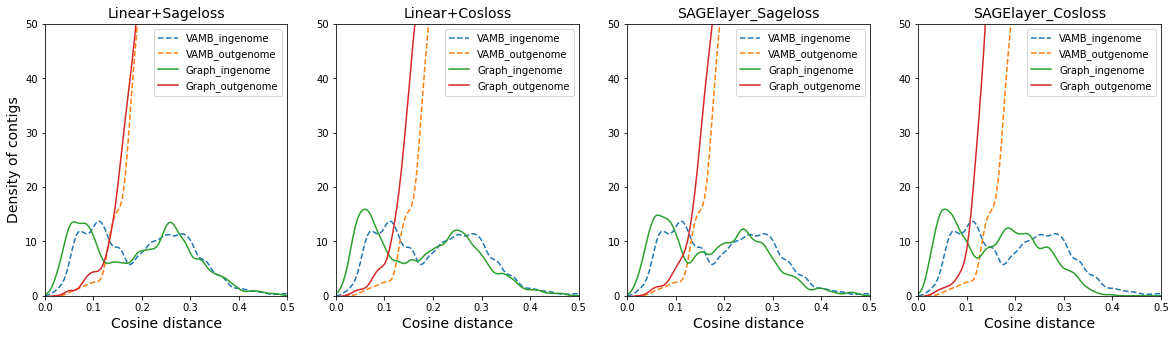

In [337]:
# plot overlap curve for 4 z models
genome_idx = 99

lin_in,lin_out = plot_ratio(lat_ori,genome_idx,ratios_ori,genome_contig,'Original')
lin_sage_in,lin_sage_out = plot_ratio(lat_lin_sage,genome_idx,ratios_lin_sage,genome_contig,'Graph-layer')
lin_cos_in,lin_cos_out = plot_ratio(lat_lin_cos,genome_idx,ratios_lin_cos,genome_contig,'Graph-layer')
sage_cos_in,sage_cos_out = plot_ratio(lat_sage_cos,genome_idx,ratios_sage_cos,genome_contig,'Graph-layer')
sage_sage_in,sage_sage_out = plot_ratio(lat_sage_sage,genome_idx,ratios_sage_sage,genome_contig,'Graph-layer')

plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.plot([i*0.005 for i in range(180)],lin_in,linestyle='--',label='VAMB_ingenome')
plt.plot([i*0.005 for i in range(180)],lin_out,linestyle='--',label='VAMB_outgenome')
plt.plot([i*0.005 for i in range(180)],lin_sage_in,linestyle='-',label='Graph_ingenome')
plt.plot([i*0.005 for i in range(180)],lin_sage_out,linestyle='-',label='Graph_outgenome')
plt.xlim(0,0.5)
plt.ylim(0,50)
plt.xlabel('Cosine distance',fontdict={'fontsize':14})
plt.ylabel('Density of contigs',fontdict={'fontsize':14})
plt.title('Linear+Sageloss',fontdict={'fontsize':14})
plt.legend()

plt.subplot(1,4,2)
plt.plot([i*0.005 for i in range(180)],lin_in,linestyle='--',label='VAMB_ingenome')
plt.plot([i*0.005 for i in range(180)],lin_out,linestyle='--',label='VAMB_outgenome')
plt.plot([i*0.005 for i in range(180)],lin_cos_in,linestyle='-',label='Graph_ingenome')
plt.plot([i*0.005 for i in range(180)],lin_cos_out,linestyle='-',label='Graph_outgenome')
plt.xlim(0,0.5)
plt.ylim(0,50)
plt.xlabel('Cosine distance',fontdict={'fontsize':14})
# plt.ylabel('Density of contigs',fontdict={'fontsize':14})
plt.title('Linear+Cosloss',fontdict={'fontsize':14})
plt.legend()

plt.subplot(1,4,3)
plt.plot([i*0.005 for i in range(180)],lin_in,linestyle='--',label='VAMB_ingenome')
plt.plot([i*0.005 for i in range(180)],lin_out,linestyle='--',label='VAMB_outgenome')
plt.plot([i*0.005 for i in range(180)],sage_sage_in,linestyle='-',label='Graph_ingenome')
plt.plot([i*0.005 for i in range(180)],sage_sage_out,linestyle='-',label='Graph_outgenome')
plt.xlim(0,0.5)
plt.ylim(0,50)
plt.xlabel('Cosine distance',fontdict={'fontsize':14})
# plt.ylabel('Density of contigs',fontdict={'fontsize':14})
plt.title('SAGElayer_Sageloss',fontdict={'fontsize':14})
plt.legend()

plt.subplot(1,4,4)
plt.plot([i*0.005 for i in range(180)],lin_in,linestyle='--',label='VAMB_ingenome')
plt.plot([i*0.005 for i in range(180)],lin_out,linestyle='--',label='VAMB_outgenome')
plt.plot([i*0.005 for i in range(180)],sage_cos_in,linestyle='-',label='Graph_ingenome')
plt.plot([i*0.005 for i in range(180)],sage_cos_out,linestyle='-',label='Graph_outgenome')
plt.xlim(0,0.5)
plt.ylim(0,50)
plt.xlabel('Cosine distance',fontdict={'fontsize':14})
# plt.ylabel('Density of contigs',fontdict={'fontsize':14})
plt.title('SAGElayer_Cosloss',fontdict={'fontsize':14})
plt.legend()
plt.savefig('graphvamb_plot/overlap_curve3.png',dpi=300)

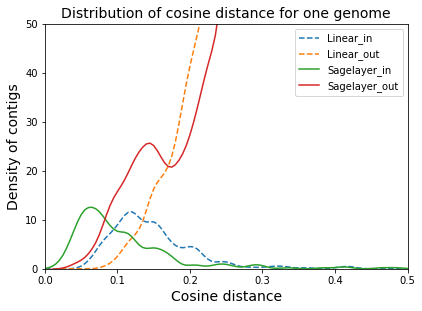

In [189]:
with open('genome_contigs_oral_pt.json','r') as f:
    genome_contigs = json.load(f)

dataset = 'oral'
matrix_ori = _torch.load('original/oral/latent_oral_0502_ori.npz')
lat_ori = vamb4.cluster._normalize(matrix_ori)
matrix_sage = _torch.load('sage_nodist/graph/oral/latent_oral_0506.npz')
lat_sage = vamb4.cluster._normalize(matrix_sage)

genome_idx = 17

lin_in,lin_out = plot_ratio(lat_ori,genome_idx,ratios_dict_ori[dataset],genome_contigs,'Original')
graph_in,graph_out = plot_ratio(lat_sage,genome_idx,ratios_dict_sage[dataset],genome_contigs,'GraphSage-layer')

plt.figure(figsize=(6.5,4.5))
plt.plot([i*0.005 for i in range(180)],lin_in,linestyle='--',label='Linear_in')
plt.plot([i*0.005 for i in range(180)],lin_out,linestyle='--',label='Linear_out')
plt.plot([i*0.005 for i in range(180)],graph_in,linestyle='-',label='Sagelayer_in')
plt.plot([i*0.005 for i in range(180)],graph_out,linestyle='-',label='Sagelayer_out')
plt.xlim(0,0.5)
plt.ylim(0,50)
plt.xlabel('Cosine distance',fontdict={'fontsize':14})
plt.ylabel('Density of contigs',fontdict={'fontsize':14})
plt.title('Distribution of cosine distance for one genome',fontdict={'fontsize':14})
plt.legend()
plt.savefig('graphvamb_plot/lin_sagenodict_curve.png',dpi=300)

### create mean distance boxplots for 9 models

In [146]:
def calc_mean_distance(matrix,genome_names,genome_contig_dict):
    mean_dist = dict()
    for genome_i in genome_names:
        mean_distance = 999999999
        center = 0
        # get the index of within genome contigs
        ingenome_idx = genome_contig_dict[genome_i]
        for contig_id in ingenome_idx:
            own_genome_mean_distance = _torch.mean(_calc_distances(matrix,contig_id)[ingenome_idx])
            if own_genome_mean_distance < mean_distance:
                center = contig_id
                mean_distance = own_genome_mean_distance

        mean_dist[genome_i] = (mean_distance,center,len(ingenome_idx))
    return mean_dist


In [148]:
# calculate the distionary of mean distance for 9 models
mean_dist_ori = calc_mean_distance(lat_ori,choose_genomes,genome_contigs)
mean_dist_lin_cos = calc_mean_distance(lat_lin_cos,choose_genomes,genome_contigs)
mean_dist_lin_sage = calc_mean_distance(lat_lin_sage,choose_genomes,genome_contigs)
mean_dist_sage_cos = calc_mean_distance(lat_sage_cos,choose_genomes,genome_contigs)
mean_dist_sage_sage = calc_mean_distance(lat_sage_sage,choose_genomes,genome_contigs)
mean_dist_lin_cos_mu = calc_mean_distance(lat_lin_cos_mu,choose_genomes,genome_contigs)
mean_dist_lin_sage_mu = calc_mean_distance(lat_lin_sage_mu,choose_genomes,genome_contigs)
mean_dist_sage_cos_mu = calc_mean_distance(lat_sage_cos_mu,choose_genomes,genome_contigs)
mean_dist_sage_sage_mu = calc_mean_distance(lat_sage_sage_mu,choose_genomes,genome_contigs)

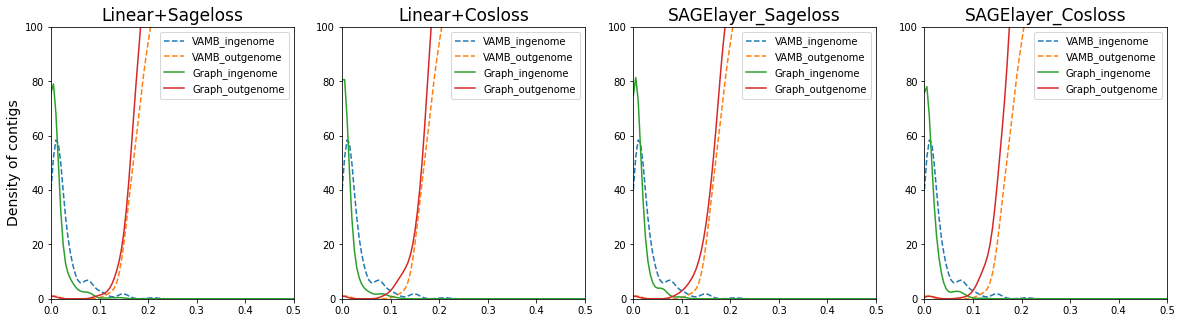

In [338]:
genome_idx = 81

lin_in,lin_out = plot_ratio(lat_ori,genome_idx,mean_dist_ori,genome_contig,'Original')
lin_sage_in,lin_sage_out = plot_ratio(lat_lin_sage,genome_idx,mean_dist_lin_sage,genome_contig,'Graph-layer')
lin_cos_in,lin_cos_out = plot_ratio(lat_lin_cos,genome_idx,mean_dist_lin_cos,genome_contig,'Graph-layer')
sage_cos_in,sage_cos_out = plot_ratio(lat_sage_cos,genome_idx,mean_dist_sage_cos,genome_contig,'Graph-layer')
sage_sage_in,sage_sage_out = plot_ratio(lat_sage_sage,genome_idx,mean_dist_sage_sage,genome_contig,'Graph-layer')

plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.plot([i*0.005 for i in range(180)],lin_in,linestyle='--',label='VAMB_ingenome')
plt.plot([i*0.005 for i in range(180)],lin_out,linestyle='--',label='VAMB_outgenome')
plt.plot([i*0.005 for i in range(180)],lin_sage_in,linestyle='-',label='Graph_ingenome')
plt.plot([i*0.005 for i in range(180)],lin_sage_out,linestyle='-',label='Graph_outgenome')
plt.xlim(0,0.5)
plt.ylim(0,100)
# plt.xlabel('Cosine distance',fontdict={'fontsize':14})
plt.ylabel('Density of contigs',fontdict={'fontsize':14})
plt.title('Linear+Sageloss',fontdict={'fontsize':17})
plt.legend()

plt.subplot(1,4,2)
plt.plot([i*0.005 for i in range(180)],lin_in,linestyle='--',label='VAMB_ingenome')
plt.plot([i*0.005 for i in range(180)],lin_out,linestyle='--',label='VAMB_outgenome')
plt.plot([i*0.005 for i in range(180)],lin_cos_in,linestyle='-',label='Graph_ingenome')
plt.plot([i*0.005 for i in range(180)],lin_cos_out,linestyle='-',label='Graph_outgenome')
plt.xlim(0,0.5)
plt.ylim(0,100)
# plt.xlabel('Cosine distance',fontdict={'fontsize':14})
# plt.ylabel('Density of contigs',fontdict={'fontsize':14})
plt.title('Linear+Cosloss',fontdict={'fontsize':17})
plt.legend()

plt.subplot(1,4,3)
plt.plot([i*0.005 for i in range(180)],lin_in,linestyle='--',label='VAMB_ingenome')
plt.plot([i*0.005 for i in range(180)],lin_out,linestyle='--',label='VAMB_outgenome')
plt.plot([i*0.005 for i in range(180)],sage_sage_in,linestyle='-',label='Graph_ingenome')
plt.plot([i*0.005 for i in range(180)],sage_sage_out,linestyle='-',label='Graph_outgenome')
plt.xlim(0,0.5)
plt.ylim(0,100)
# plt.xlabel('Cosine distance',fontdict={'fontsize':14})
# plt.ylabel('Density of contigs',fontdict={'fontsize':14})
plt.title('SAGElayer_Sageloss',fontdict={'fontsize':17})
plt.legend()

plt.subplot(1,4,4)
plt.plot([i*0.005 for i in range(180)],lin_in,linestyle='--',label='VAMB_ingenome')
plt.plot([i*0.005 for i in range(180)],lin_out,linestyle='--',label='VAMB_outgenome')
plt.plot([i*0.005 for i in range(180)],sage_cos_in,linestyle='-',label='Graph_ingenome')
plt.plot([i*0.005 for i in range(180)],sage_cos_out,linestyle='-',label='Graph_outgenome')
plt.xlim(0,0.5)
plt.ylim(0,100)
# plt.xlabel('Cosine distance',fontdict={'fontsize':14})
# plt.ylabel('Density of contigs',fontdict={'fontsize':14})
plt.title('SAGElayer_Cosloss',fontdict={'fontsize':17})
plt.legend()

plt.savefig('graphvamb_plot/overlap_curve1.png',dpi=300)

In [275]:
# create the pandas dataframe
mean_dist_dict_list_ori = [mean_dist_ori] * 4
mean_dist_value_list_ori = [[values[0].item() for values in mean_dist_dict.values()] for mean_dist_dict in mean_dist_dict_list_ori]
name_list = ['Linear+\nCosloss','Linear+\nSageloss','Sagelayer+\nCosloss','Sagelayer+\nSageloss']

df_ori_list = []
for i,model_name in enumerate(name_list):
    df = pd.DataFrame({'mean_distance':mean_dist_value_list_ori[i]})
    df['model'] = model_name
    df_ori_list.append(df)
df_ori = pd.concat(df_ori_list)
df_ori['latent'] = 'VAMB'

# df for z models
mean_dist_dict_list_z = [mean_dist_lin_cos,mean_dist_lin_sage,mean_dist_sage_cos,mean_dist_sage_sage]
mean_dist_value_list_z = [[values[0].item() for values in mean_dist_dict.values()] for mean_dist_dict in mean_dist_dict_list_z]
name_list = ['Linear+\nCosloss','Linear+\nSageloss','Sagelayer+\nCosloss','Sagelayer+\nSageloss']

df_z_list = []
for i,model_name in enumerate(name_list):
    df = pd.DataFrame({'mean_distance':mean_dist_value_list_z[i]})
    df['model'] = model_name
    df_z_list.append(df)
df_z = pd.concat(df_z_list)
df_z['latent'] = 'Graphloss_z'

# df for mu models
mean_dist_dict_list_mu = [mean_dist_lin_cos_mu,mean_dist_lin_sage_mu,mean_dist_sage_cos_mu,mean_dist_sage_sage_mu]
mean_dist_value_list_mu = [[values[0].item() for values in mean_dist_dict.values()] for mean_dist_dict in mean_dist_dict_list_mu]

df_mu_list = []
for i,model_name in enumerate(name_list):
    df = pd.DataFrame({'mean_distance':mean_dist_value_list_mu[i]})
    df['model'] = model_name
    df_mu_list.append(df)
df_mu = pd.concat(df_mu_list)
df_mu['latent'] = 'Graphloss_mu'

# concatenate z and mu df
df_both = pd.concat([df_ori,df_mu,df_z])

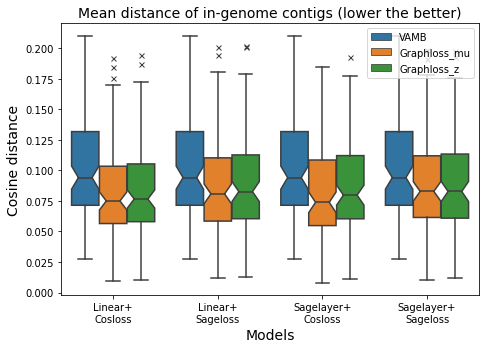

In [276]:
# make boxplot using sns
fig, ax = plt.subplots(figsize=(7.5, 5))
sns.boxplot(data=df_both,x='model',y='mean_distance',hue='latent',notch=True, flierprops={"marker": "x"},ax=ax)
ax.set_xlabel('Models',fontdict={'fontsize':14})
ax.set_ylabel('Cosine distance',fontdict={'fontsize':14})
ax.legend(loc='upper right')
ax.set_title('Mean distance of in-genome contigs (lower the better)',fontdict={'fontsize':14})

plt.savefig('graphvamb_plot/meandist_boxplot.png',dpi=300)

In [243]:
def calc_mean_out(matrix, mean_dist_dict, genome_contigs_dict):
    mean_out = []
    for genome_i,(_,center,_) in mean_dist_dict.items():
        outgenome_idx = [i for i in range(len(matrix)) if i not in genome_contigs_dict[genome_i]]

        dist = _calc_distances(matrix,center)
        without_distances = dist[outgenome_idx]
        mean_distout = _torch.mean(without_distances)
        mean_out.append(mean_distout.item())
    return mean_out
    

In [244]:
out_ori = calc_mean_out(lat_ori,mean_dist_ori,genome_contigs)

out_lin_cos = calc_mean_out(lat_lin_cos,mean_dist_lin_cos,genome_contigs)
out_lin_sage = calc_mean_out(lat_lin_sage,mean_dist_lin_sage,genome_contigs)
out_sage_cos = calc_mean_out(lat_sage_cos,mean_dist_sage_cos,genome_contigs)
out_sage_sage = calc_mean_out(lat_sage_sage,mean_dist_sage_sage,genome_contigs)
out_lin_cos_mu = calc_mean_out(lat_lin_cos_mu,mean_dist_lin_cos_mu,genome_contigs)
out_lin_sage_mu = calc_mean_out(lat_lin_sage_mu,mean_dist_lin_sage_mu,genome_contigs)
out_sage_cos_mu = calc_mean_out(lat_sage_cos_mu,mean_dist_sage_cos_mu,genome_contigs)
out_sage_sage_mu = calc_mean_out(lat_sage_sage_mu,mean_dist_sage_sage_mu,genome_contigs)

In [259]:
with open('errorfree/thesis_ef/ori/ratios_0510ori_200_0.json','r') as f:
    ratios_ori = json.load(f)

In [252]:
ratios_dict_list_z = []
fold_name_list = ['lin_cos','lin_sage','sage_cos','sage_sage']

for fold_name in fold_name_list:
    with open('errorfree/thesis_ef/{}/ratios_0510_200_0.1.json'.format(fold_name),'r') as f:
        a = json.load(f)
    ratios_dict_list_z.append(a)

len(ratios_dict_list_z)

4

In [253]:
ratios_dict_list_mu = []

for fold_name in fold_name_list:
    with open('errorfree/thesis_ef/{}/ratios_0510mu_200_0.1.json'.format(fold_name),'r') as f:
        b = json.load(f)
    ratios_dict_list_mu.append(b)
len(ratios_dict_list_mu)

4

In [280]:
# create the pandas dataframe
ratios_dict_list_ori = [ratios_ori] * 4
ratios_value_list_ori = [[values[0] for values in ratios_dict.values()] for ratios_dict in ratios_dict_list_ori]
name_list = ['Linear+\nCosloss','Linear+\nSageloss','Sagelayer+\nCosloss','Sagelayer+\nSageloss']

df_ori_list = []
for i,model_name in enumerate(name_list):
    df = pd.DataFrame({'Overlap ratios':ratios_value_list_ori[i]})
    df['model'] = model_name
    df_ori_list.append(df)
df_ori = pd.concat(df_ori_list)
df_ori['latent'] = 'VAMB'

# df for z models
ratios_value_list_z = [[values[0] for values in ratios_dict.values()] for ratios_dict in ratios_dict_list_z]
name_list = ['Linear+\nCosloss','Linear+\nSageloss','Sagelayer+\nCosloss','Sagelayer+\nSageloss']

df_z_list = []
for i,model_name in enumerate(name_list):
    df = pd.DataFrame({'Overlap ratios':ratios_value_list_z[i]})
    df['model'] = model_name
    df_z_list.append(df)
df_z = pd.concat(df_z_list)
df_z['latent'] = 'Graphloss_z'

# df for mu models
ratios_value_list_mu = [[values[0] for values in ratios_dict.values()] for ratios_dict in ratios_dict_list_mu]

df_mu_list = []
for i,model_name in enumerate(name_list):
    df = pd.DataFrame({'Overlap ratios':ratios_value_list_mu[i]})
    df['model'] = model_name
    df_mu_list.append(df)
df_mu = pd.concat(df_mu_list)
df_mu['latent'] = 'Graphloss_mu'

# concatenate z and mu df
df_both = pd.concat([df_ori,df_mu,df_z])

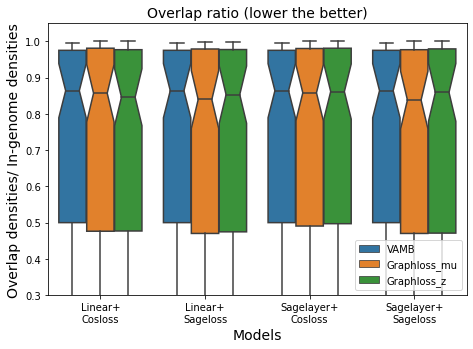

In [288]:
# make boxplot using sns
fig, ax = plt.subplots(figsize=(7.5, 5))
sns.boxplot(data=df_both,x='model',y='Overlap ratios',hue='latent',notch=True, flierprops={"marker": "x"},ax=ax)
ax.set_xlabel('Models',fontdict={'fontsize':14})
ax.set_ylabel('Overlap densities/ In-genome densities',fontdict={'fontsize':14})
ax.set_ylim(0.3)
ax.legend(loc='lower right')
ax.set_title('Overlap ratio (lower the better)',fontdict={'fontsize':14})

plt.savefig('graphvamb_plot/overlapratio_boxplot.png',dpi=300)

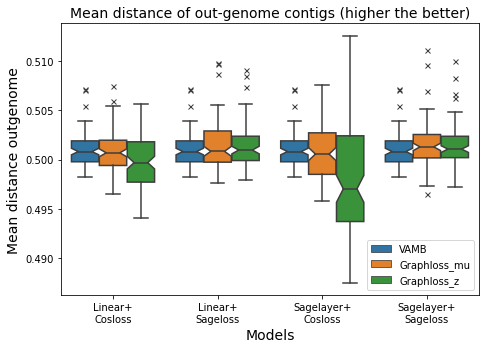

In [269]:
# create the pandas dataframe

out_list_ori = [out_ori] * 4
name_list = ['Linear+\nCosloss','Linear+\nSageloss','Sagelayer+\nCosloss','Sagelayer+\nSageloss']

df_ori_list = []
for i,model_name in enumerate(name_list):
    df = pd.DataFrame({'Mean distance out':out_list_ori[i]})
    df['model'] = model_name
    df_ori_list.append(df)
df_ori = pd.concat(df_ori_list)
df_ori['latent'] = 'VAMB'

# df for z models
out_list_z = [out_lin_cos,out_lin_sage,out_sage_cos,out_sage_sage]
name_list = ['Linear+\nCosloss','Linear+\nSageloss','Sagelayer+\nCosloss','Sagelayer+\nSageloss']

df_z_list = []
for i,model_name in enumerate(name_list):
    df = pd.DataFrame({'Mean distance out':out_list_z[i]})
    df['model'] = model_name
    df_z_list.append(df)
df_z = pd.concat(df_z_list)
df_z['latent'] = 'Graphloss_z'

# df for mu models
out_list_mu = [out_lin_cos_mu,out_lin_sage_mu,out_sage_cos_mu,out_sage_sage_mu]

df_mu_list = []
for i,model_name in enumerate(name_list):
    df = pd.DataFrame({'Mean distance out':out_list_mu[i]})
    df['model'] = model_name
    df_mu_list.append(df)
df_mu = pd.concat(df_mu_list)
df_mu['latent'] = 'Graphloss_mu'

# concatenate z and mu df
df_both = pd.concat([df_ori,df_mu,df_z])

# make boxplot using sns
fig, ax = plt.subplots(figsize=(7.5, 5))
sns.boxplot(data=df_both,x='model',y='Mean distance out',hue='latent',notch=True, flierprops={"marker": "x"},ax=ax)
ax.set_xlabel('Models',fontdict={'fontsize':14})
ax.set_ylabel('Mean distance outgenome',fontdict={'fontsize':14})
# ax.set_ylim(0.3)
ax.legend(loc='lower right')
ax.set_title('Mean distance of out-genome contigs (higher the better)',fontdict={'fontsize':14})

plt.savefig('graphvamb_plot/meandistout_boxplot.png',dpi=300)

In [290]:
with open('errorfree/sagenew_z_neg/ratios_0508_230_0.json','r') as f:
    ratios_230_0 = json.load(f)
with open('errorfree/sagenew_z_neg/ratios_0508_230_0.02.json','r') as f:
    ratios_230_002 = json.load(f)
with open('errorfree/sagenew_z_neg/ratios_0508_230_0.05.json','r') as f:
    ratios_230_005 = json.load(f)
with open('errorfree/sagenew_z_neg/ratios_0509_230_0.01.json','r') as f:
    ratios_230_001 = json.load(f)
with open('errorfree/sagenew_z_neg/ratios_0507_230_0.1.json','r') as f:
    ratios_230_01 = json.load(f)

In [301]:
gamma_list = [0,0.01,0.02,0.05,0.1]
ratios_gamma_list_cos = []
for gamma in gamma_list:
    with open('errorfree/thesis_ef/lin_cos/ratios_0511_230_{}.json'.format(gamma),'r') as f:
        ratios = json.load(f)
    ratios_gamma_list_cos.append(ratios)


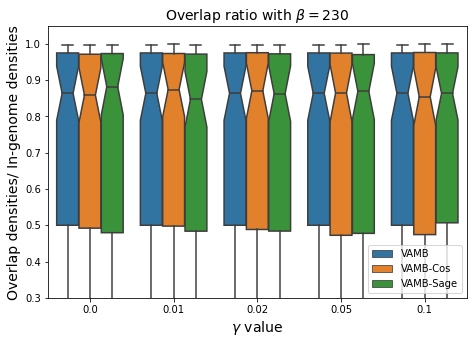

In [305]:
# create the pandas dataframe
gamma_list = [0,0.01,0.02,0.05,0.1]

ratios_dict_list_ori = [ratios_ori] * 5
ratios_value_list_ori = [[values[0] for values in ratios_dict.values()] for ratios_dict in ratios_dict_list_ori]
df_ori_list = []
for i,gamma in enumerate(gamma_list):
    df = pd.DataFrame({'Overlap ratios':ratios_value_list_ori[i]})
    df['gamma'] = gamma
    df_ori_list.append(df)
df_ori = pd.concat(df_ori_list)
df_ori['model'] = 'VAMB'

# df for sage models
ratios_gamma_list = [ratios_230_0,ratios_230_001,ratios_230_002,ratios_230_005,ratios_230_01]
ratios_value_gamma_list = [[values[0] for values in ratios_dict.values()] for ratios_dict in ratios_gamma_list]
df_gamma_list = []
for i,gamma in enumerate(gamma_list):
    df = pd.DataFrame({'Overlap ratios':ratios_value_gamma_list[i]})
    df['gamma'] = gamma
    df_gamma_list.append(df)
df_gamma = pd.concat(df_gamma_list)
df_gamma['model'] = 'VAMB-Sage'

# df for cos models
ratios_value_gamma_list_cos = [[values[0] for values in ratios_dict.values()] for ratios_dict in ratios_gamma_list_cos]
df_gamma_list_cos = []
for i,gamma in enumerate(gamma_list):
    df = pd.DataFrame({'Overlap ratios':ratios_value_gamma_list_cos[i]})
    df['gamma'] = gamma
    df_gamma_list_cos.append(df)
df_gamma_cos = pd.concat(df_gamma_list_cos)
df_gamma_cos['model'] = 'VAMB-Cos'

# concatenate z and mu df
df_both = pd.concat([df_ori,df_gamma_cos,df_gamma])

# make boxplot using sns
fig, ax = plt.subplots(figsize=(7.5, 5))
sns.boxplot(data=df_both,x='gamma',y='Overlap ratios',hue='model',notch=True, flierprops={"marker": "x"},ax=ax)
ax.set_xlabel(r'$\gamma$ value',fontdict={'fontsize':14})
ax.set_ylabel('Overlap densities/ In-genome densities',fontdict={'fontsize':14})
ax.set_ylim(0.3)
ax.legend(loc='lower right')
ax.set_title(r'Overlap ratio with $\beta=230$',fontdict={'fontsize':14})

plt.savefig('graphvamb_plot/overratio_boxplot_gamma.png',dpi=300)